In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import re
import math
import statistics

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score

In [2]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 50)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_seq_items', 50)
pd.set_option('display.width', 100)

In [3]:
#chargement des base de données
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_order_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_order_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_order_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_product_category_name = pd.read_csv('Data/product_category_name_translation.csv')

## Fonctions

In [4]:
def deg2rad(x):
    return math.pi*x/180

def get_distance_m(lat1, lng1, lat2, lng2):
    earth_radius = 6378137   # Terre = sphère de 6378km de rayon
    rlo1 = deg2rad(lng1)    # CONVERSION
    rla1 = deg2rad(lat1)
    rlo2 = deg2rad(lng2)
    rla2 = deg2rad(lat2)
    dlo = (rlo2 - rlo1) / 2
    dla = (rla2 - rla1) / 2
    a = (np.sin(dla) * np.sin(dla)) + np.cos(rla1) * np.cos(rla2) * (np.sin(dlo) * np.sin(dlo))
    d = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return (earth_radius * d)

In [5]:
def dataGenerate(timeDelta):
  df_orders_gen = df_orders[df_orders['order_purchase_timestamp'] < (df_orders['order_purchase_timestamp'].max() - pd.to_timedelta(timeDelta, unit='D'))]
  df = pd.DataFrame({'customer_unique_id' : df_orders_gen['customer_unique_id'].value_counts().index})
  df = df.merge(df_customers.groupby('customer_unique_id').first()['customer_city'], on='customer_unique_id')

  city_count = df['customer_city'].value_counts()
  df['customer_city_size'] = df['customer_city'].apply(lambda x: city_count[x])
  df['customer_city_size_log'] = np.log(df['customer_city_size'])
  df.drop(['customer_city', 'customer_city_size'], axis=1, inplace=True)

  # Merge df_orders
  order_agg = {
              'customer_id': 'count',
              'order_purchase_timestamp': 'max',
              'payment_value': 'sum'
              }
  df = df.merge(df_orders_gen.groupby('customer_unique_id').agg(order_agg), on='customer_unique_id')
  
  # Merge df_order_items
  order_items_agg = {'price': 'mean',
                     'freight_value': 'mean',
                     'orthodromique_distance_log': 'mean',
                     'product_volume_log': 'mean'
                    }
  df = df.merge(df_order_items.groupby('customer_unique_id').agg(order_items_agg), on='customer_unique_id')
  
  # fillna
  fill_dicf = {
              'orthodromique_distance_log': df['orthodromique_distance_log'].mean(),
              'product_volume_log': df['product_volume_log'].mean()
             }
  df.fillna(fill_dicf, inplace=True)
  
  df['order_purchase_timestamp'] = (df['order_purchase_timestamp'].max() - df['order_purchase_timestamp']).astype('timedelta64[h]')/24
  return df

## Nettoyage de base

In [6]:
# prepare customers
df_geolocation = df_geolocation.groupby(['geolocation_zip_code_prefix']).mean()
df_customers = df_customers.merge(df_geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')
df_customers['customer_city'] = df_customers['customer_city'].str.title()

# prépare order
df_orders = df_orders.merge(df_customers[['customer_unique_id', 'customer_id']], on='customer_id')
df_orders = df_orders.merge(df_order_reviews, on='order_id', how='left')

# keep only last review if multiple
df_orders = df_orders.sort_values(by='review_answer_timestamp').drop_duplicates(subset=['order_id'], keep='last')

df_payment = pd.DataFrame({'order_id' : df_order_payments['order_id'].value_counts().index, 'number_of_payment' : df_order_payments['order_id'].value_counts()})
df_payment = df_payment.merge(df_order_payments[['order_id', 'payment_value']].groupby('order_id').sum(), on='order_id')
df_orders = df_orders.merge(df_payment, on='order_id')
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders['order_purchase_timestamp'], format='%Y-%m-%d %H:%M:%S')

# prépare order items
df_sellers = df_sellers.merge(df_geolocation, left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
df_order_items = df_order_items.merge(df_sellers, on='seller_id', how='left')
df_order_items = df_order_items.merge(df_products, on='product_id', how='left')
df_order_items = df_order_items.merge(df_orders[['order_id', 'customer_unique_id']], on='order_id')

df_order_items = df_order_items.merge(df_customers[['customer_unique_id', 'geolocation_lat', 'geolocation_lng']], on="customer_unique_id", suffixes=('_seller', '_customer'))
df_order_items['orthodromique_distance'] = get_distance_m(df_order_items['geolocation_lat_seller'], df_order_items['geolocation_lng_seller'], df_order_items['geolocation_lat_customer'], df_order_items['geolocation_lng_customer'])
df_order_items['orthodromique_distance_log'] = np.log(df_order_items['orthodromique_distance']+1)
df_order_items['product_volume'] = df_order_items['product_height_cm'] * df_order_items['product_length_cm'] * df_order_items['product_width_cm']
df_order_items['product_volume_log'] = np.log(df_order_items[['product_volume']]+1)


## Bug

In [12]:
df = dataGenerate(0)
X = df.drop(['customer_unique_id', 'customer_id'], axis=1).values
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
M1 = KMeans(n_clusters=3)
M2 = KMeans(n_clusters=3)
M1.fit(X_std)
M2.fit(X_std)

# c'est cette ligne qui provoque le bug
print(adjusted_rand_score(M2.predict(X_std), M1.predict(X_std)))

# et avec cette ligne le bug n'apparait pas
#print(adjusted_rand_score(M1.predict(X_std[:60000]), M2.predict(X_std[:60000])))

0.9995899642016524


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))


In [13]:
M1.predict(X_std)

array([2, 2, 2, ..., 2, 0, 0])

In [14]:
M2.predict(X_std)

array([1, 1, 1, ..., 1, 2, 2])

## Modeling

In [16]:
step_range = range(10, 300, 20)
df_step = pd.DataFrame(columns=['mean', 'perf', 'step', 'shape_first', 'shape_last', 'shape_last_mean'], index=step_range)

for step in tqdm(step_range):
  perf = []
  shapef = []
  shapel = []
  for intarval in range(0, 400, step):
    df_first = dataGenerate(intarval + step)
    df_last = dataGenerate(intarval)
    shapef.append(df_first.shape[0])
    shapel.append(df_last.shape[0])
    Xf = df_first.drop(['customer_unique_id', 'customer_id'], axis=1).values
    Xl = df_last.drop(['customer_unique_id', 'customer_id'], axis=1).values
    
    # Modeling
    scalerM0 = StandardScaler()
    scalerM0.fit(Xf)
    Xf_M0 = scalerM0.transform(Xf)
    model_0 = KMeans(n_clusters=3)
    model_0.fit(Xf_M0)
    scalerM1 = StandardScaler()
    scalerM1.fit(Xl)
    
    Xl_M0 = scalerM0.transform(Xl)
    Xl_M1 = scalerM1.transform(Xl)
    model_1 = KMeans(n_clusters=3)
    model_1.fit(Xl_M1)
    if Xl.shape[0] < 60000:
      perf.append(adjusted_rand_score(model_0.predict(Xl_M0),model_1.predict(Xl_M1)))
    else:
      perf.append(adjusted_rand_score(model_0.predict(Xl_M0[:60000]),model_1.predict(Xl_M1[:60000])))
  df_step.loc[step, 'mean'] = statistics.mean(perf)
  df_step.loc[step, 'perf'] = perf
  df_step.loc[step, 'step'] = step
  df_step.loc[step, 'shape_first'] = shapef
  df_step.loc[step, 'shape_last'] = shapel
  df_step.loc[step, 'shape_last_mean'] = statistics.mean(shapel)

  0%|          | 0/15 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\Progra

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
 13%|█▎        | 2/15 [13:37<1:20:48, 372.99s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn 

 87%|████████▋ | 13/15 [22:35<01:08, 34.26s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
 93%|█████████▎| 14/15 [22:52<00:28, 29.00s/it]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in longlong_scalars
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in longlong_scalars
  (tp + fp) * (fp + tn))
100%|██████████| 15/15 [23:11<00:00, 92.79s/it]


In [18]:
df_step

,mean,perf,step,shape_first,shape_last,shape_last_mean
10,-1.087476,"[0.8778207160903205, 0.8985033396951045, 0.8293207318411643, 0.9710590843322746, 0.9169960536161...",10,"[95155, 95155, 95155, 95155, 95132, 93752, 91227, 88269, 86063, 84297, 82729, 80698, 78606, 7680...","[95155, 95155, 95155, 95155, 95155, 95132, 93752, 91227, 88269, 86063, 84297, 82729, 80698, 7860...",63718.875
30,-0.493864,"[0.6161302708375316, 0.8485727556661559, 0.31404408512994214, -1.1394675878489602, -5.9630765004...",30,"[95155, 93752, 86063, 80698, 75465, 68160, 61595, 54395, 47865, 42258, 34148, 29514, 25376, 21261]","[95155, 95155, 93752, 86063, 80698, 75465, 68160, 61595, 54395, 47865, 42258, 34148, 29514, 25376]",63542.785714
50,-0.465048,"[0.5108108008697118, 0.6252352326386288, -1.8437226122316674, -6.710597513054229, 0.927477424927...",50,"[95132, 84297, 75465, 63645, 52295, 42258, 30862, 23848]","[95155, 95132, 84297, 75465, 63645, 52295, 42258, 30862]",67388.625
70,-1.615474,"[0.6449684327309723, 1.7051618692828043, -14.728668772246166, 0.8965513397294317, 0.873969155220...",70,"[91227, 76807, 61595, 45446, 30862, 21261]","[95155, 91227, 76807, 61595, 45446, 30862]",66848.666667
90,-0.024355,"[0.6719433448828094, -1.2789519662974498, -1.2328431839437384, 0.8550959443256274, 0.86298328358...",90,"[86063, 68160, 47865, 29514, 17236]","[95155, 86063, 68160, 47865, 29514]",65351.4
110,-0.249514,"[0.6668600439671715, -3.324996794714883, 0.806990910119906, 0.8530905974659674]",110,"[82729, 59210, 34148, 18587]","[95155, 82729, 59210, 34148]",67810.5
130,7.3634,"[0.6235138973877916, 27.342533796708487, 0.8040577047213642, 0.6834965170802059]",130,"[78606, 50052, 25376, 9302]","[95155, 78606, 50052, 25376]",62297.25
150,-1.518231,"[0.45530017035974285, -5.769738481612019, 0.7597463479816339]",150,"[75465, 42258, 17236]","[95155, 75465, 42258]",70959.333333
170,-0.176699,"[0.21010701178645572, -1.4340048263964271, 0.6937998236054433]",170,"[70311, 32315, 10585]","[95155, 70311, 32315]",65927
190,-0.051456,"[0.024999430069502164, -0.7382577815108821, 0.5588907560820375]",190,"[65806, 26600, 4907]","[95155, 65806, 26600]",62520.333333


(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

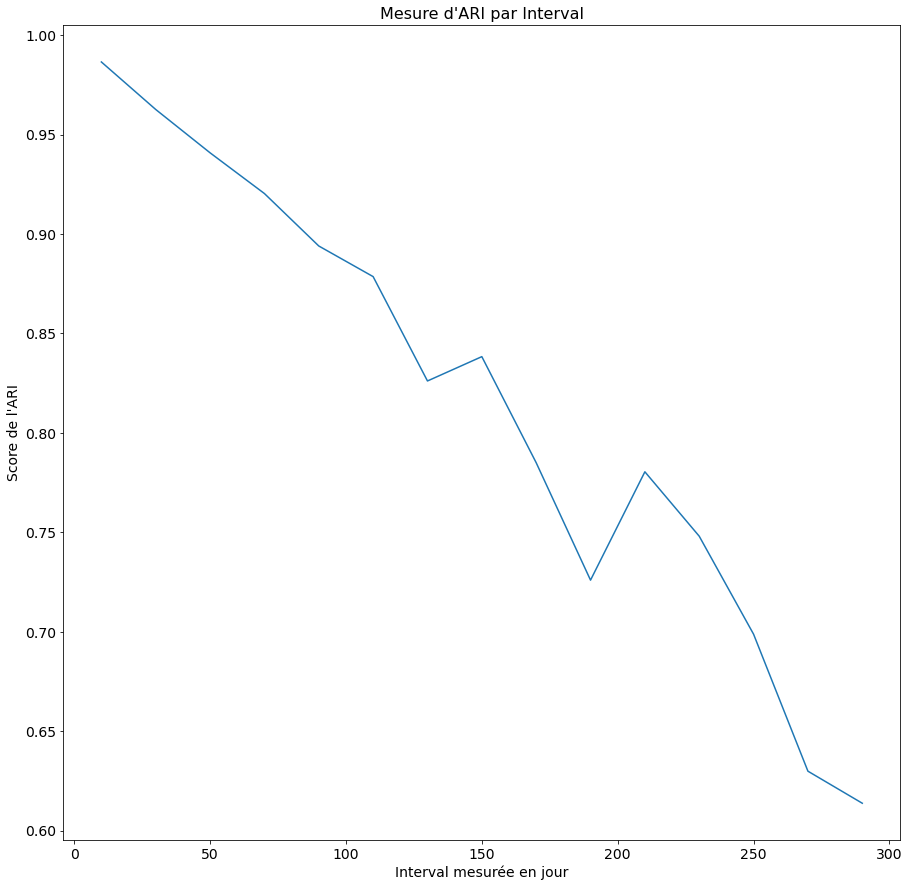

In [33]:
plt.figure(figsize=(15,15))
df_step['mean'].plot()
plt.title('Mesure d\'ARI par Interval', fontsize=16)
plt.xlabel("Interval mesurée en jour", fontsize=14)
plt.ylabel("Score de l'ARI", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

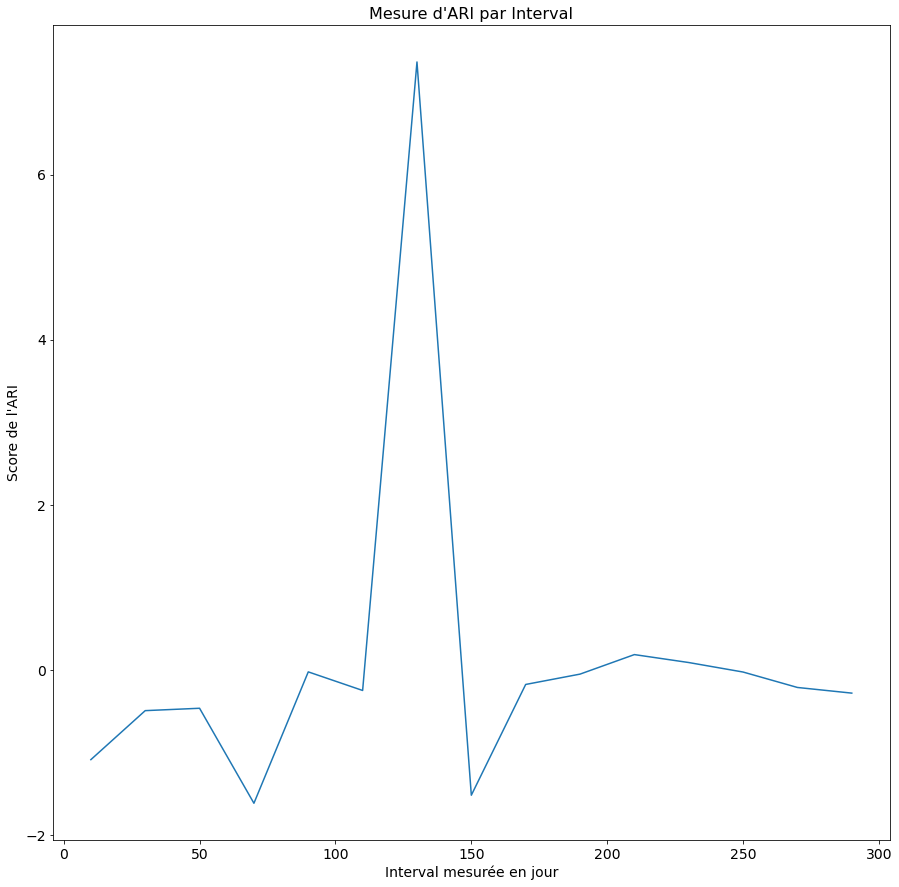

In [17]:
plt.figure(figsize=(15,15))
df_step['mean'].plot()
plt.title('Mesure d\'ARI par Interval', fontsize=16)
plt.xlabel("Interval mesurée en jour", fontsize=14)
plt.ylabel("Score de l'ARI", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

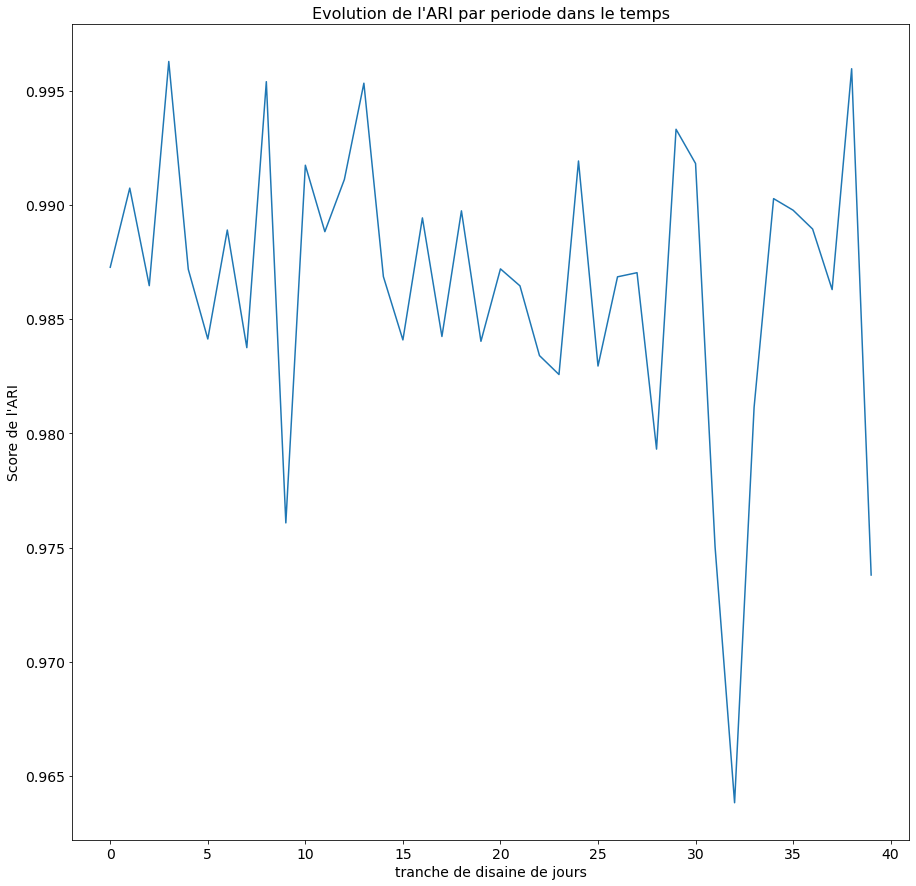

In [34]:

plt.figure(figsize=(15,15))
plt.plot(df_step.loc[10,'perf'])
plt.title('Evolution de l\'ARI par periode dans le temps', fontsize=16)
plt.xlabel("tranche de disaine de jours", fontsize=14)
plt.ylabel("Score de l'ARI", fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)